In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT, TARGET_SERIES, TARGET_INDICATOR

sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tar = ut.load_target()
PANEL_SCORE = True

## increasing values

In [3]:
series = 'IV'
px, px_ca, px_us = ut.load_series(series)

int: 6.18220627203e-16	coef: 0.543239747314


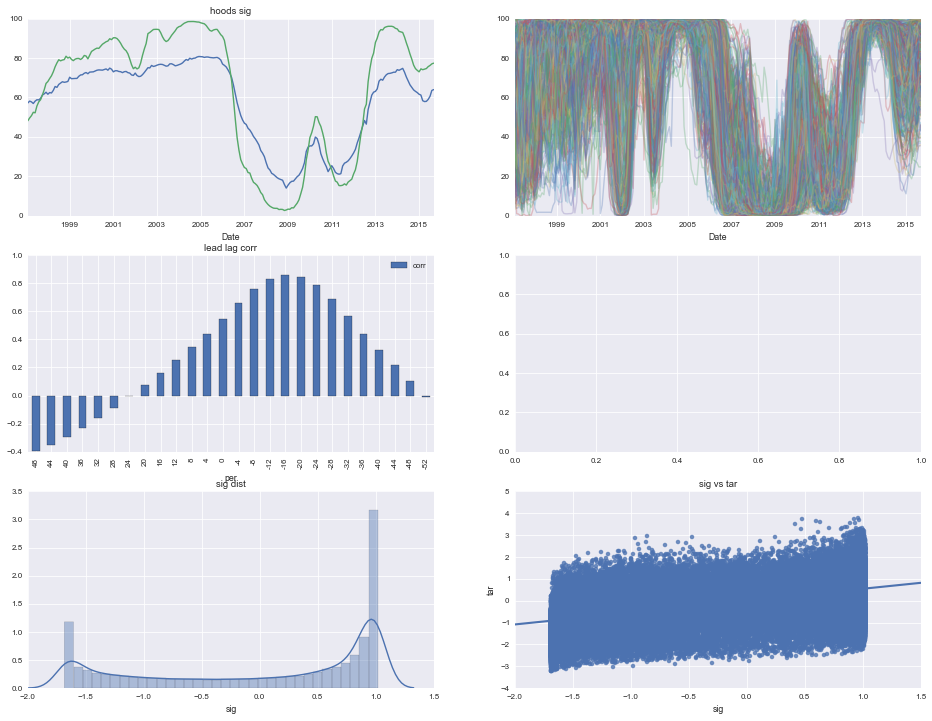

In [146]:
ut.explore_series(px, px_ca, px_us, tar)

## decreasing values

In [31]:
series = 'DV'
px, px_ca, px_us = ut.load_series(series)

int: -9.72514953918e-15	coef: -0.539402120121


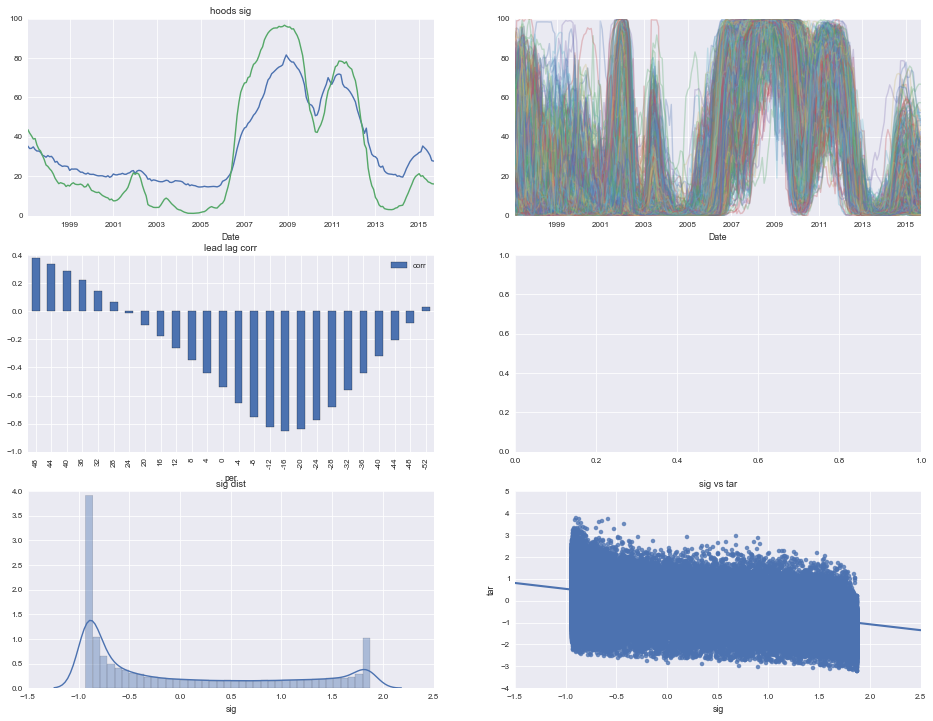

In [32]:
ut.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [33]:
series = 'SLPR'
px, px_ca, px_us = ut.load_series(series)

In [34]:
px

,00003,00004,00007,00014,00021,00025,00032,00034,00035,00037,...,01028,01145,01213,01535,01987,02046,02637,04463,04531,05903
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-28,0.9954,0.99,0.9937,0.9801,0.9857,0.9987,0.9783,0.9757,0.9872,1.0667,...,0.9734,0.9812,1,0.9747,0.9699,0.9608,0.993141,1.0821,0.9697,0.9956


## turnover in housing market in past year

In [35]:
series = 'SPY'
px, px_ca, px_us = ut.load_series(series)

int: -4.63035810897e-15	coef: 0.12150467813


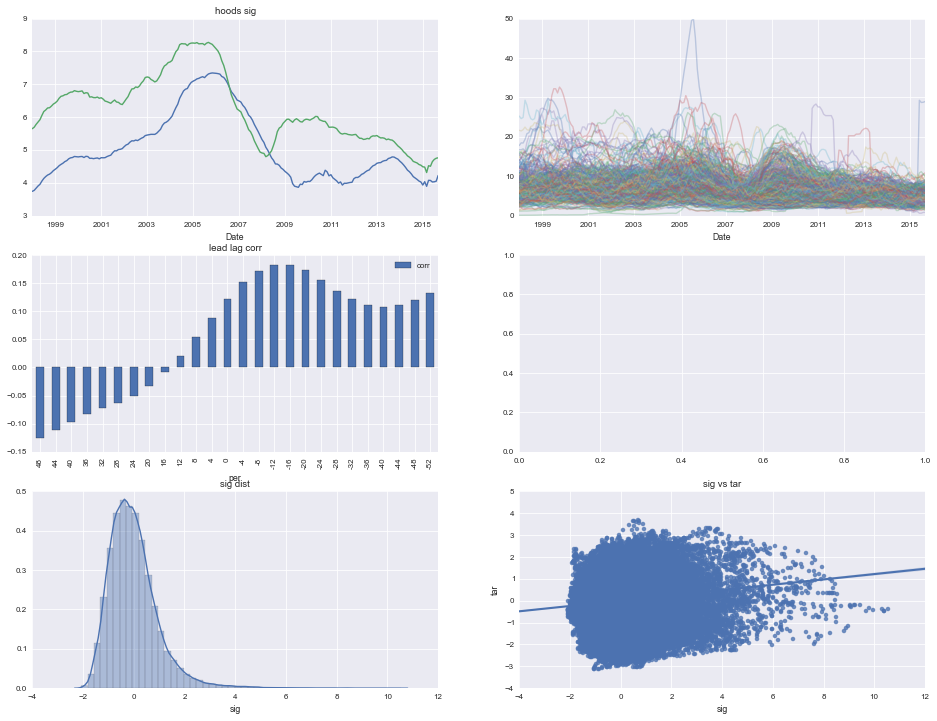

In [36]:
ut.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [38]:
series = 'SFG'
px, px_ca, px_us = ut.load_series(series)

In [39]:
yoy = lambda x: x / x.shift(12) - 1.
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
SFG_c = px

int: 4.45931763155e-15	coef: 0.158829595428


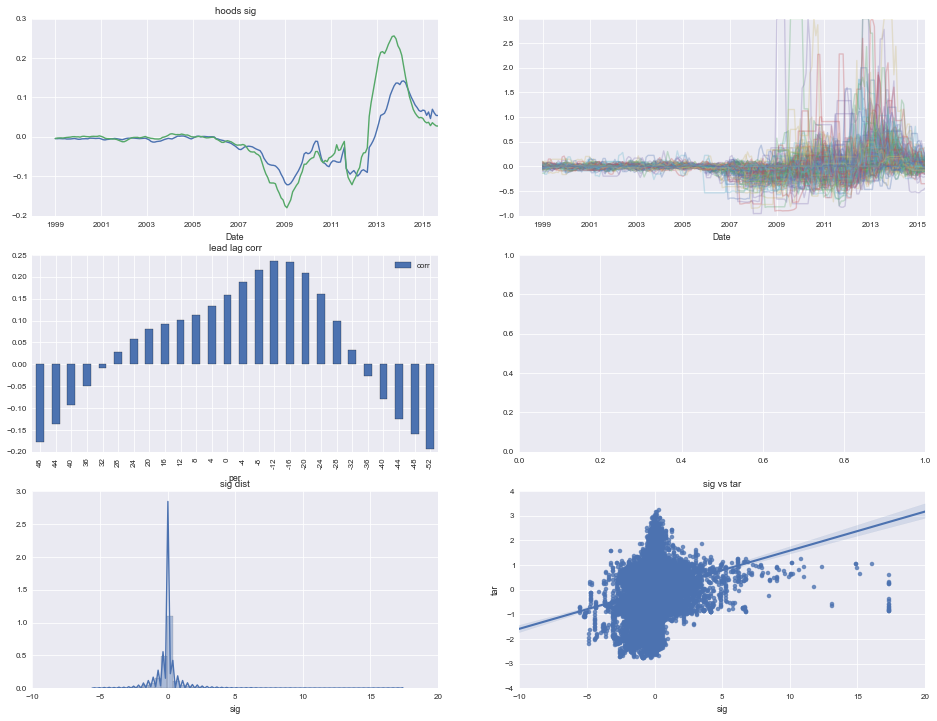

In [39]:
ut.explore_series(px, px_ca, px_us, tar)

# price per square foot

In [40]:
series = 'MVSF'
px, px_ca, px_us = ut.load_series(series)

In [41]:
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
MVSF_c = px

int: -2.85943207518e-14	coef: 0.488553051962


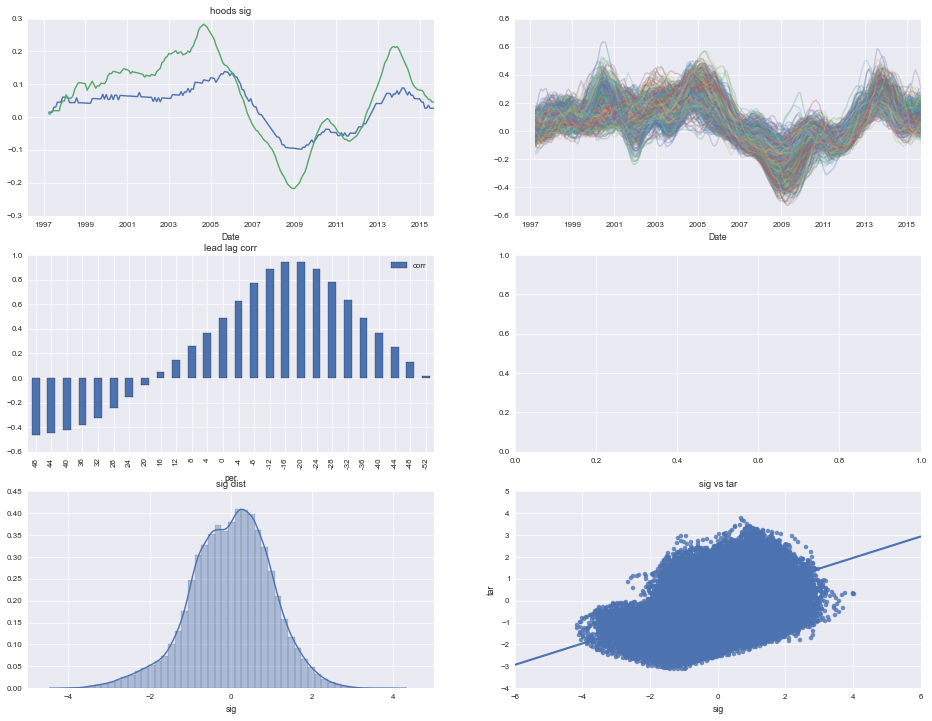

In [22]:
ut.explore_series(px, px_ca, px_us, tar)

# momentum

In [42]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [43]:
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
TAR_mom = px

int: -2.08862042335e-14	coef: 0.329269714338


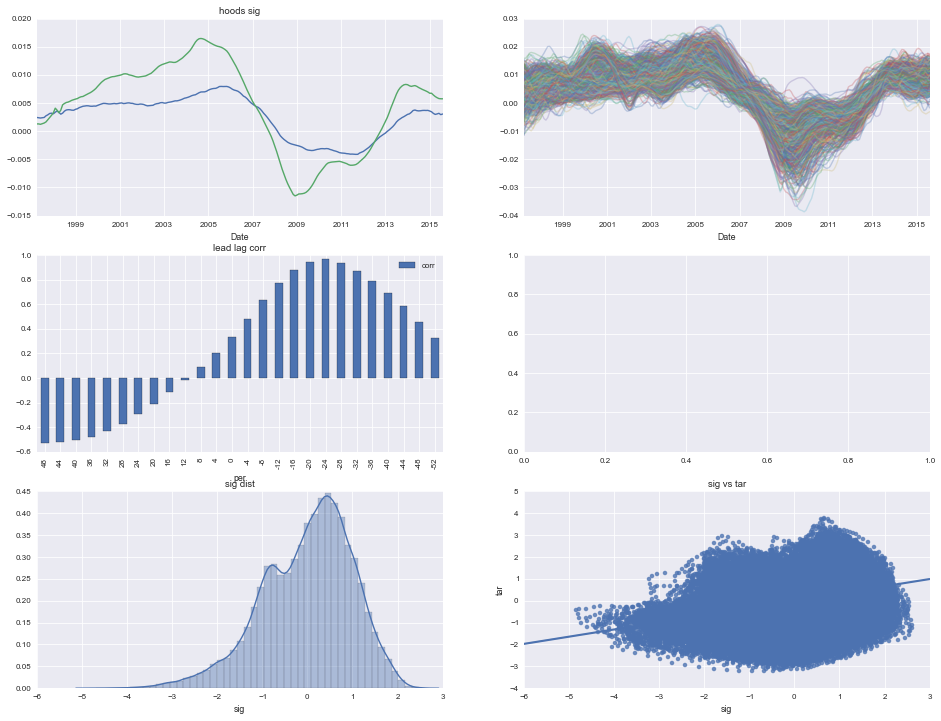

In [19]:
ut.explore_series(px, px_ca, px_us, tar)

# change in momentum

In [44]:
px, px_ca, px_us = ut.load_series(TARGET_SERIES)

In [45]:
def momentum_change(df):
        mom_cur = ut.momentum(df)
        mom_prev = ut.momentum(df.shift(12))
        return (mom_cur - mom_prev).dropna(how='all')

In [46]:
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
TAR_mom_chg = px

int: -8.61038192251e-15	coef: 0.548548622923


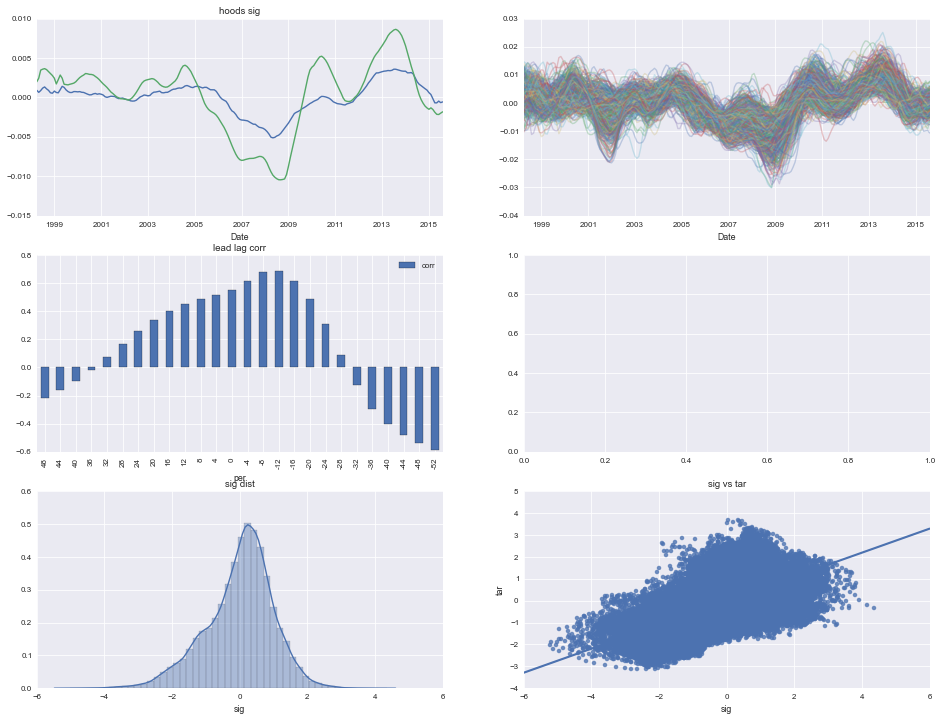

In [34]:
ut.explore_series(px, px_ca, px_us, tar)

## build model

In [47]:
features = {}
for i in ('IV', 'DV', 'SPY'):
    features[i] = ut.load_quandl_data('hoods', i)
features['tar'] = tar
features['SFG'] = SFG_c
features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df = ut.ts_score(df, panel=PANEL_SCORE)

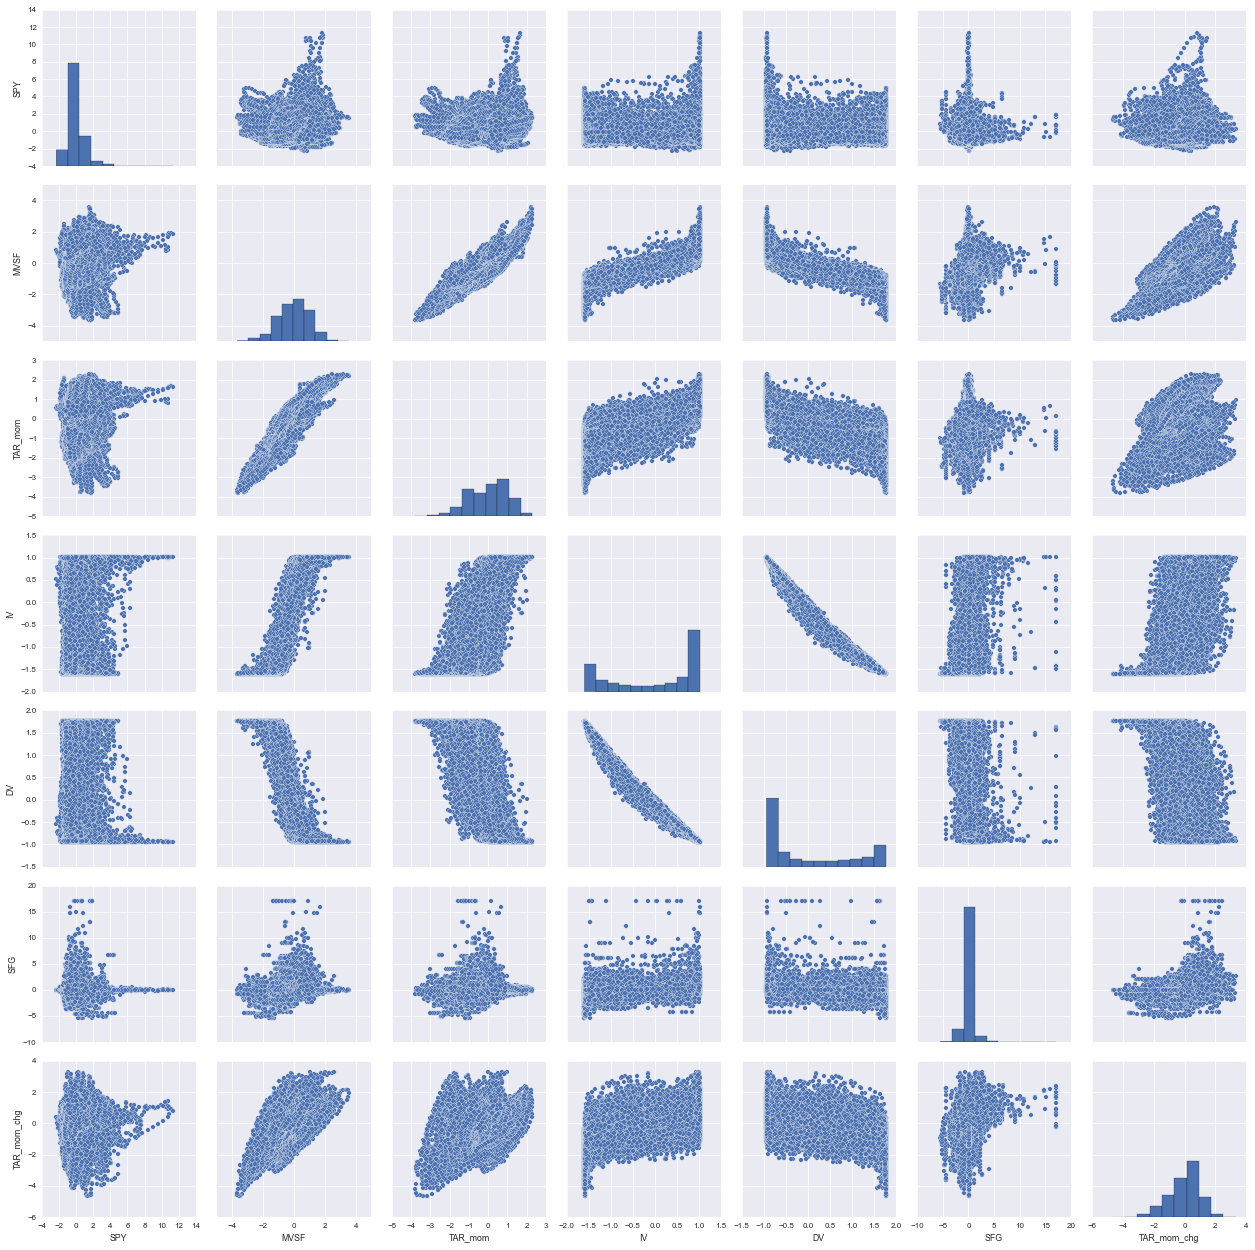

In [48]:
sns.pairplot(df[[c for c in df.columns if c != 'tar']])

sharpe ratios:
0.2    1.189292
0.4    1.810271
0.6    2.220296
0.8    2.468665
1.0    2.459862
mkt    1.837193
dtype: float64

r2: 0.344147091815	int: 3.56761787587e-15	coef: [-0.00387857  0.08535846  0.02245011  0.10963039 -0.10311821  0.01620451
  0.15887531]	alpha: 50000


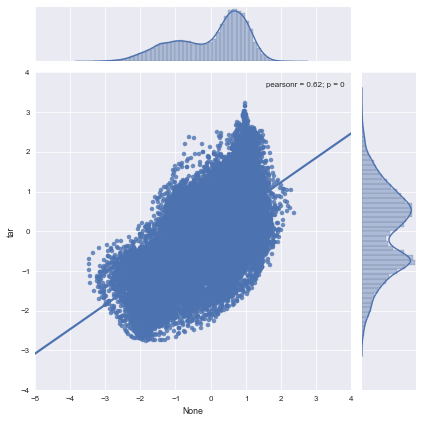

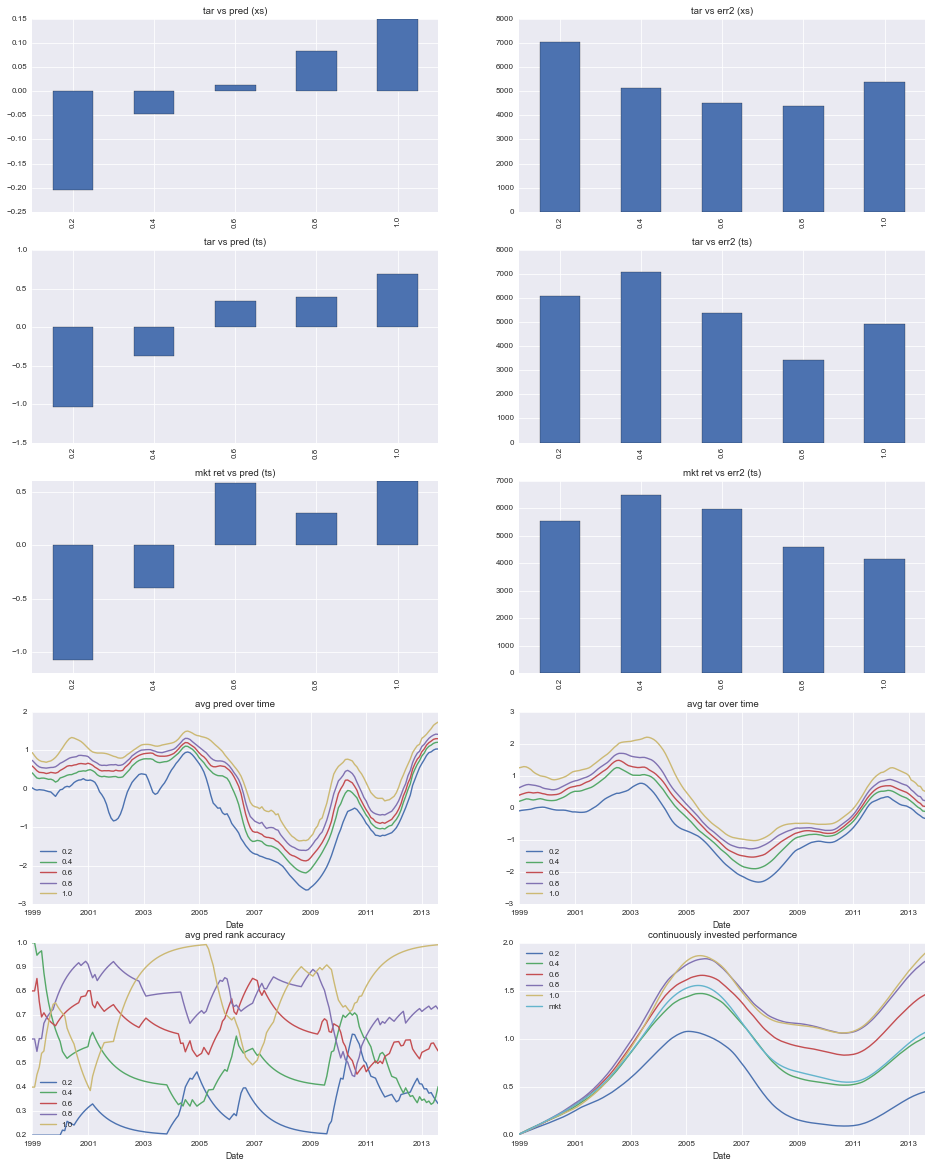

In [51]:
clf = lm.RidgeCV(alphas=[1., 10., 100, 1000, 10000, 50000, 10000000], cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    1.170032
0.4    1.768106
0.6    2.214967
0.8    2.482365
1.0    2.523114
mkt    1.837193
dtype: float64

r2: 0.393839077099	int: 2.95442991592e-15	coef: [-0.          0.          0.          0.2744558  -0.          0.
  0.31488798]	alpha: 0.1


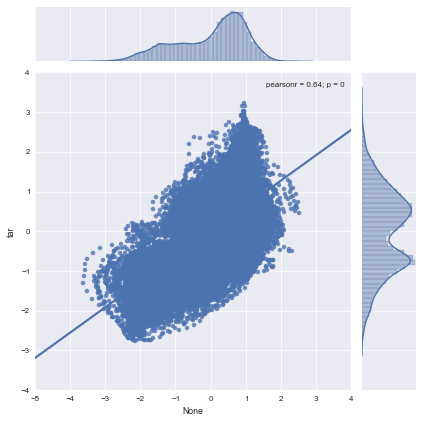

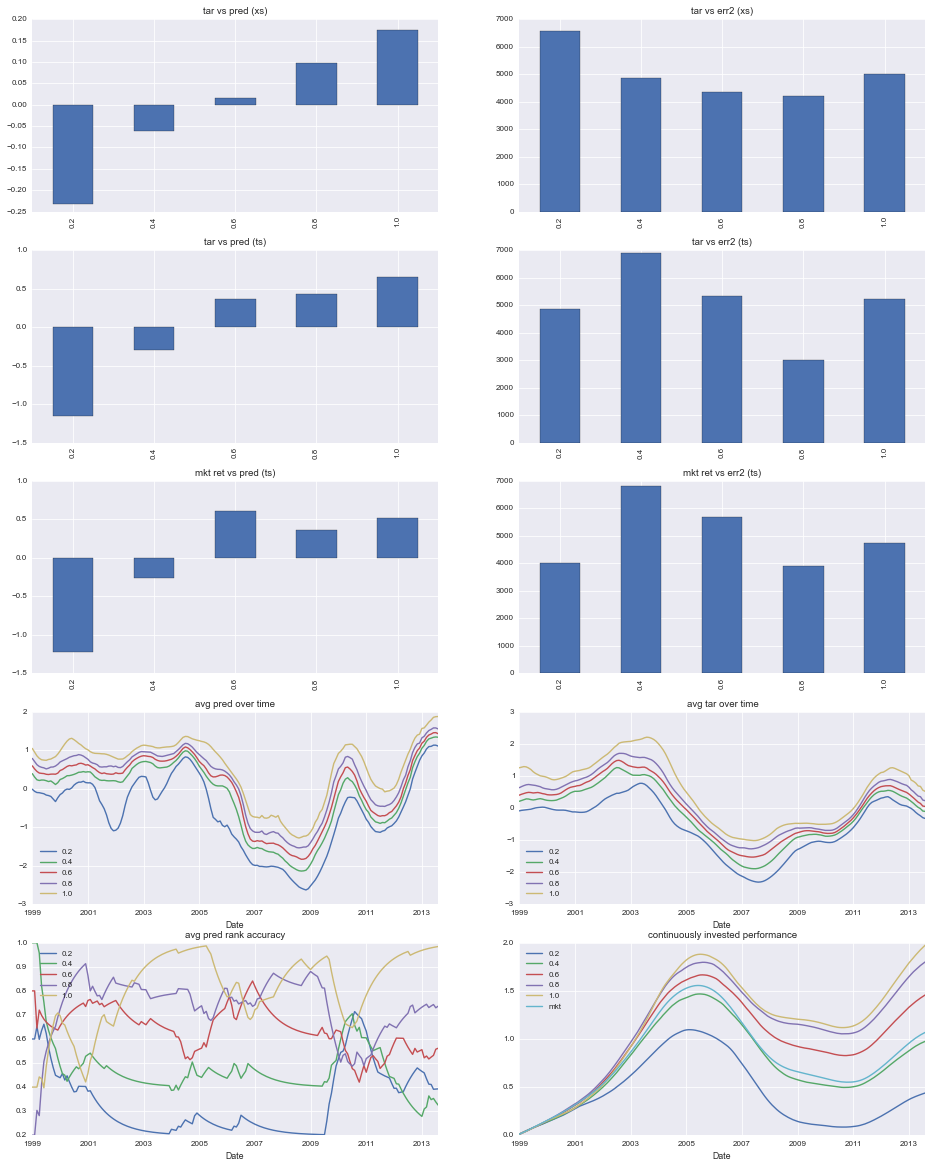

In [52]:
clf = lm.LassoCV(alphas=[.0001, .001, .01, .1], cv=5)
clf, df_res, score = ut.build_model(clf, df)
score = clf.score(df[[c for c in df.columns if c != 'tar']], df['tar'])
print
print('r2: {2}\tint: {0}\tcoef: {1}\talpha: {3}'.format(clf.intercept_, clf.coef_, score, clf.alpha_))

sharpe ratios:
0.2    3.031080
0.4    2.897693
0.6   -1.016407
0.8   -0.954023
1.0   -0.211361
mkt    1.686712
dtype: float64

r2: 0.511016442392


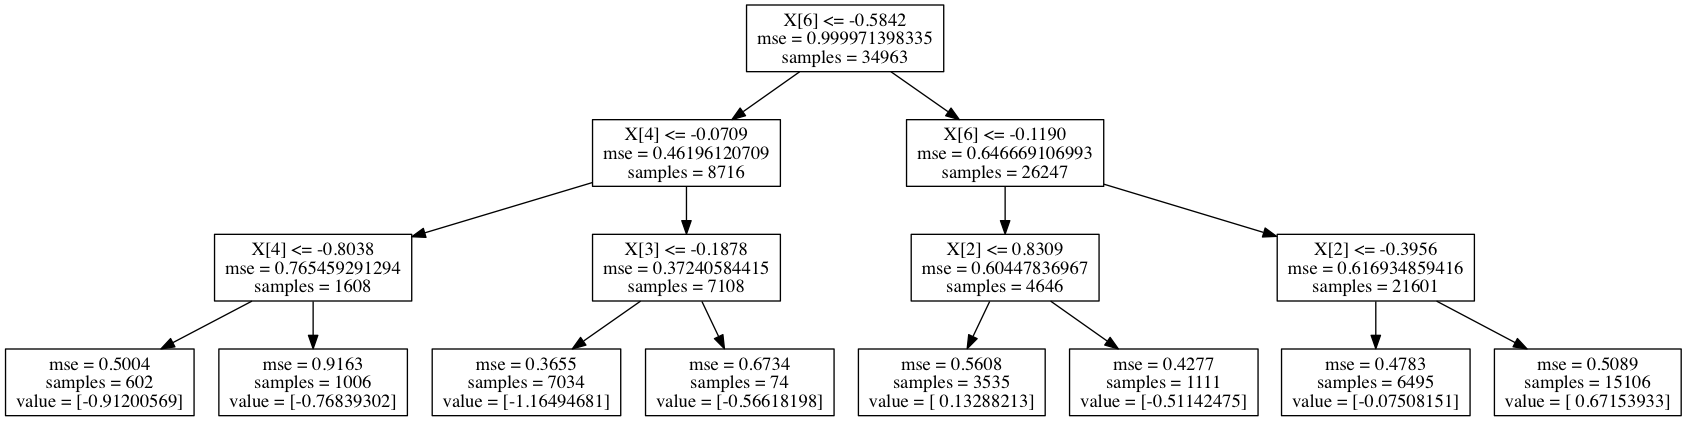

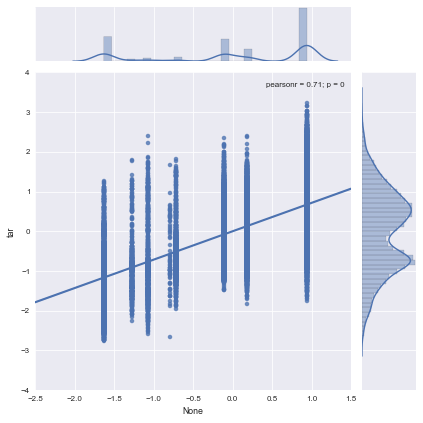

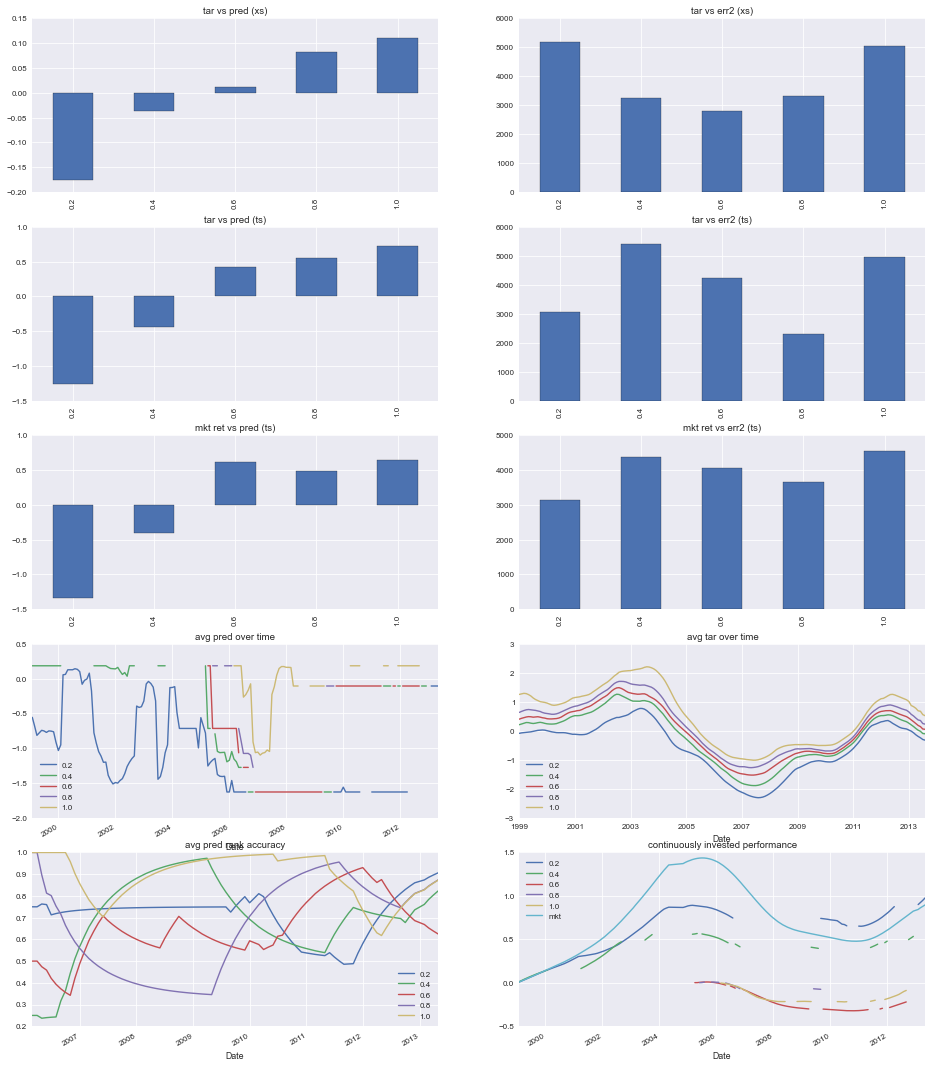

In [53]:
clf = GridSearchCV(tree.DecisionTreeRegressor(), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))
ut.tree_vis(clf.best_estimator_)

sharpe ratios:
0.2    1.274651
0.4    1.917386
0.6    2.124438
0.8    2.356874
1.0    2.440981
mkt    1.837193
dtype: float64

r2: 0.454296094266


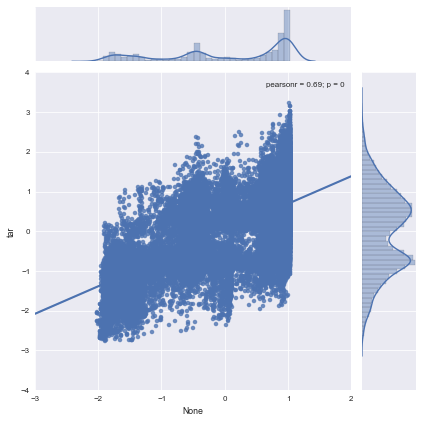

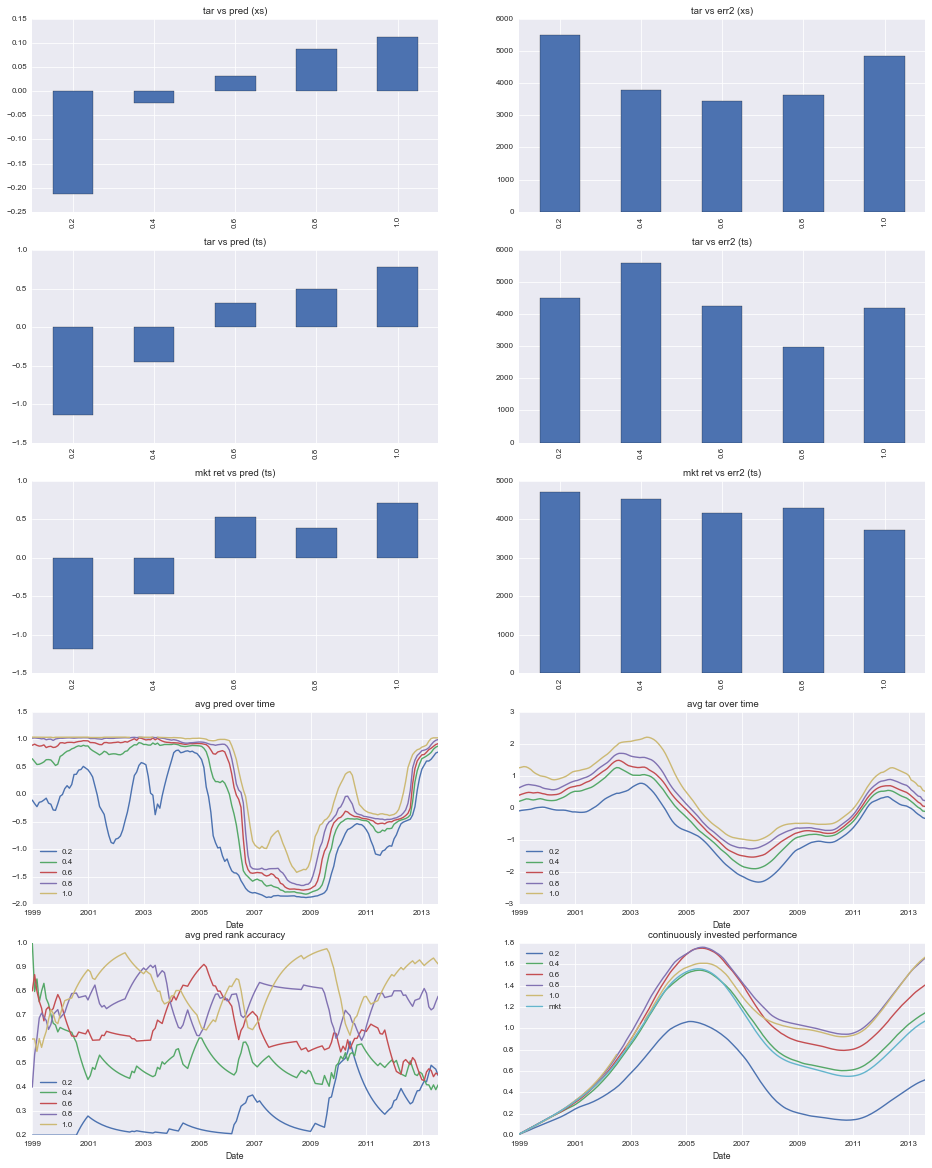

In [54]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid={'max_depth': [3,5,7], 'max_features': [None, 1, 2]}, cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))

sharpe ratios:
0.2    1.490027
0.4    1.893536
0.6    2.020619
0.8    2.238408
1.0    1.787739
mkt    1.837193
dtype: float64

r2: 0.48498020112


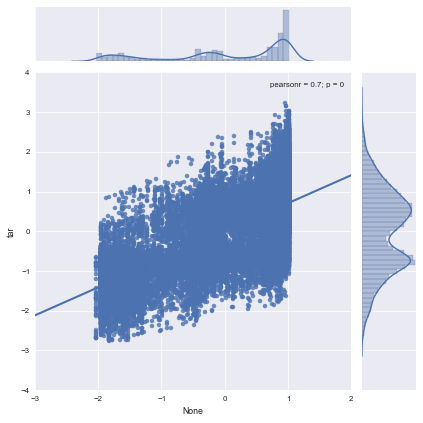

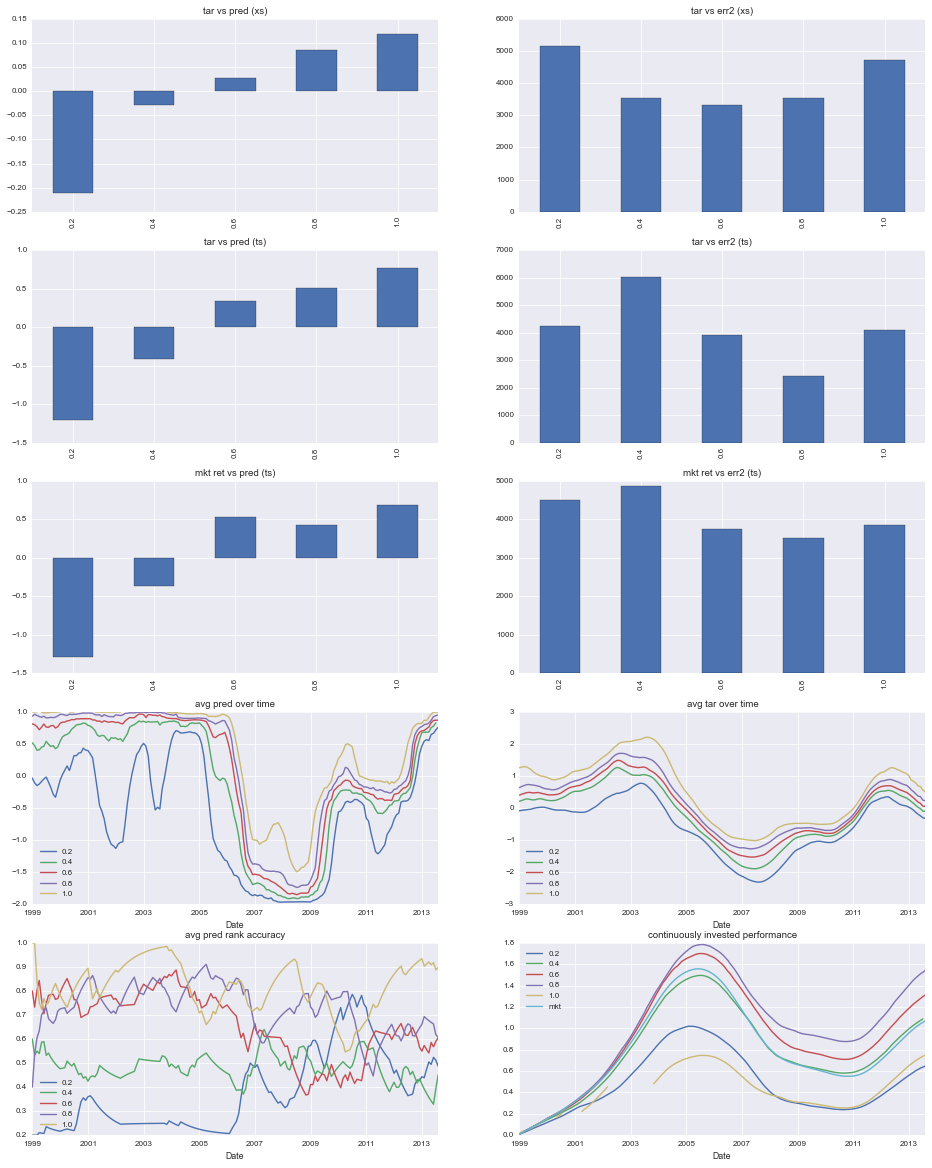

In [55]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 100, 200],
                                                            'max_depth': [1,3,5], 
                                                            'max_features': [None, 1, 2]}, 
                   cv=5)
clf, df_res, score = ut.build_model(clf, df)
print
print('r2: {0}'.format(score,))